In [1]:
import pandas as pd
import numpy as np
import time
import sys

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn import svm

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/'
if module_path not in sys.path:
    sys.path.append(module_path)

from integrating_embedding import *

module_path='/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/supervised_learning/'
if module_path not in sys.path:
    sys.path.append(module_path)
    
from evaluation import *

In [2]:
emb_path_trn_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_train.npy'
emb_path_vld_mimic = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_valid.npy'

emb_path_trn_eicu = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/Train/result/emb_eicu.npy'

mimic_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/MIMIC-IV-COHORT.csv.gz'
eicu_path = '/Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection/eICU-COHORT.csv.gz'

mimic_train_emb, mimic_valid_emb = integrating(mimic_path, emb_path_trn_mimic, emb_path_vld_mimic, 'mimic')
eicu_test_emb = integrating(eicu_path, emb_path_trn_eicu, emb_path_trn_eicu, 'eicu')

========== 데이터셋 분할 정보 ==========
데이터셋 비율: 학습 = 0.70, 테스트 = 0.30
학습셋 클래스 비율: 1    387626
2     11118
3     13863
4      3838
Name: classes, dtype: int64
테스트셋 클래스 비율: 1    157229
2      4903
3      6157
4      1666
Name: classes, dtype: int64
--------------------------------------
========== 클래스 비율 ==========
학습셋 클래스 비율: 0.93:0.03:0.03:0.01
테스트셋 클래스 비율: 0.93:0.03:0.04:0.01
--------------------------------------
========== 환자 및 체류 정보 ==========
학습셋 환자 수: 6820
테스트셋 환자 수: 2923
학습셋 체류 수: 7096
테스트셋 체류 수: 3050
--------------------------------------
========== 실험 설정 ==========
분할 시드: 9040
학습 비율: 0.7
임계값: 0.05
--------------------------------------
========== 실행 결과 ==========
총 소요 시간(초): 0.43
시도한 시행 횟수: 0


In [3]:
circ_data = mimic_train_emb[(mimic_train_emb['Annotation'] == 'circ')|(mimic_train_emb['Annotation'] == 'ambiguous')]
circ_data_sample = circ_data.sample(frac=0.2, random_state=1) 

non_circ_data = mimic_train_emb[(mimic_train_emb['Annotation'] == 'no_circ')]
# non_circ_data = mimic_train_emb[(mimic_train_emb['Annotation'] == 'no_circ')|(mimic_train_emb['Annotation'] == 'ambiguous')]

new_dataset = pd.concat([circ_data_sample, non_circ_data])

sampled_dataset = new_dataset.reset_index(drop=True)

In [4]:
# mimic_valid_emb = mimic_valid_emb[~(mimic_valid_emb['Annotation'] == 'ambiguous')]
# eicu_test_emb = eicu_test_emb[~(eicu_test_emb['Annotation'] == 'ambiguous')]


X_train, y_train, _ = split_X_Y(sampled_dataset, mode = 'mimic')
X_valid, y_valid, valid_output = split_X_Y(mimic_valid_emb, mode = 'mimic')
X_test, y_test, test_output = split_X_Y(eicu_test_emb, mode = 'eicu')

In [5]:
lgbm_wrapper = LGBMClassifier(n_estimators=10, random_state=42)
lgbm_wrapper.fit(X_train, y_train)

valid_preds = lgbm_wrapper.predict(X_valid)
valid_output['prediction_label'] = valid_preds
valid_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_valid)[:, 1]

test_preds = lgbm_wrapper.predict(X_test)
test_output['prediction_label'] = test_preds
test_output['prediction_prob'] = lgbm_wrapper.predict_proba(X_test)[:, 1]
# pred_proba = lgbm_wrapper.predict_proba(X_valid)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16830, number of negative: 387650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.207042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50377
[LightGBM] [Info] Number of data points in the train set: 404480, number of used features: 284
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041609 -> initscore=-3.136940
[LightGBM] [Info] Start training from score -3.136940


In [7]:
import cohort_evaluation
import importlib
importlib.reload(cohort_evaluation)

<module 'cohort_evaluation' from 'c:\\Users/DAHS/Desktop/ECP_CONT/ECP_SCL/Cohort_selection\\cohort_evaluation.py'>

In [8]:
recall, precision = get_evaluation(valid_output.iloc[:, :-1], 'mimic')
recall_test, precision_test = get_evaluation(test_output.iloc[:, :-1], 'eicu')

print('mimic validation: ', recall, precision)
print('eicu test: ', recall_test, precision_test)

100%|██████████| 9847/9847 [00:08<00:00, 1182.34it/s]


mimic validation:  0.8349 0.9446786979254512
eicu test:  0.7927 0.9161607524583155


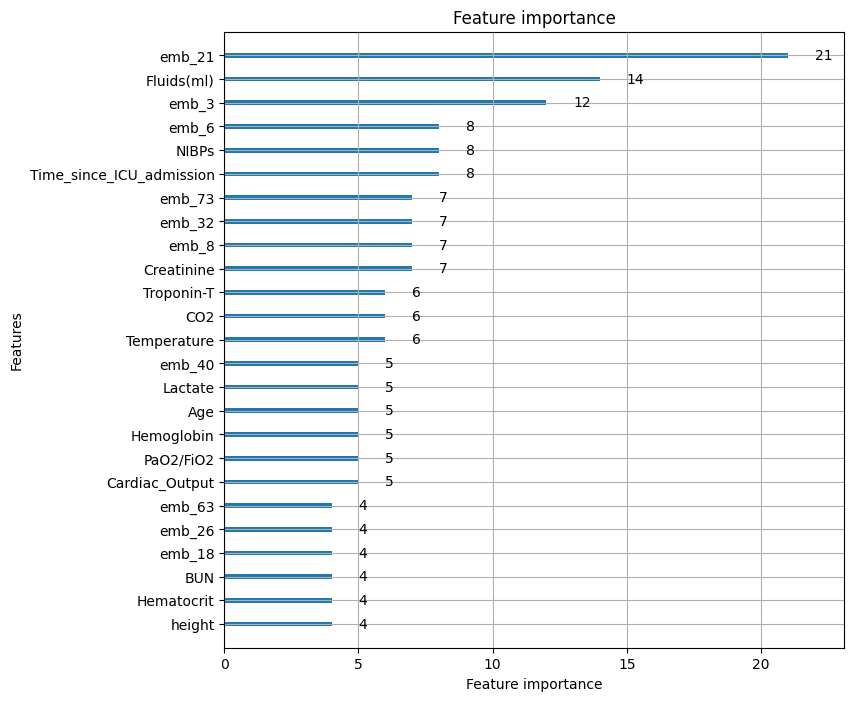

In [10]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(8,8))
plot_importance(lgbm_wrapper, max_num_features = 25, ax = ax)
plt.show()